# Birds Species Classification using MobileNetV2


In [2]:
!pwd

/keras_portfolio/Birds Species


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-04-23 15:05:49.851648: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 15:05:50.260370: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 15:05:50.260424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 15:05:50.326597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 15:05:50.469751: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_path = Path("data/")

birds = pd.read_csv(data_path / "birds.csv")
birds.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [3]:
birds.shape

(89885, 5)

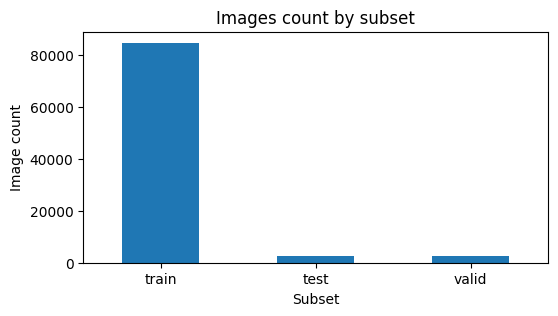

In [4]:
plt.figure(figsize=(6,3))
birds["data set"].value_counts(normalize=False).plot(kind="bar")
plt.xticks(rotation=0)
plt.title("Images count by subset")
plt.xlabel("Subset")
plt.ylabel("Image count")
plt.show()

In [56]:
birds["data set"].value_counts(normalize=True)

data set
train    0.941592
test     0.029204
valid    0.029204
Name: proportion, dtype: float64

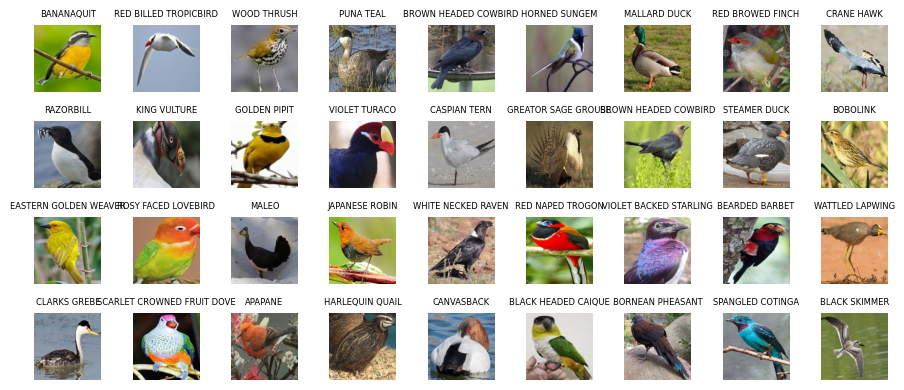

In [5]:
nrows, ncols = 4, 9
birds_sample = birds.sample(nrows*ncols)  # Solo para ejemplo, puedes eliminar esto cuando lo uses en todo el conjunto de datos

# Generar colores aleatorios para cada clase en formato hexadecimal
class_labels = np.unique(birds_sample["labels"])

plt.figure(figsize=(ncols, nrows))
for i, (_, row) in enumerate(birds_sample.iterrows()):
    class_label, filepath, label = row["labels"], row["filepaths"], row["labels"]
    img = plt.imread(data_path / filepath)

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.title(f"{label}", fontsize=6)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Cargue datos usando una utilidad Keras

Carguemos estas imágenes fuera del disco utilizando la útil utilidad **tf.keras.utils.image_dataset_from_directory** . Esto lo llevará de un directorio de imágenes en el disco a un **tf.data.Dataset** en solo un par de líneas de código.

## Crear un conjunto de datos
Defina algunos parámetros para el cargador:

In [13]:
batch_size = 64
img_shape = 96

In [14]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    data_path / "train",
    image_size=(img_shape, img_shape),
    batch_size=batch_size,
    shuffle=True,
)
test_dataset = image_dataset_from_directory(
    data_path / "test",
    image_size=(img_shape, img_shape),
    batch_size=batch_size,
    shuffle=False,
)
val_dataset = image_dataset_from_directory(
    data_path / "valid",
    image_size=(img_shape, img_shape),
    batch_size=batch_size,
    shuffle=False,
)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


## Data augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

## Visualiza los datos con data augmentation

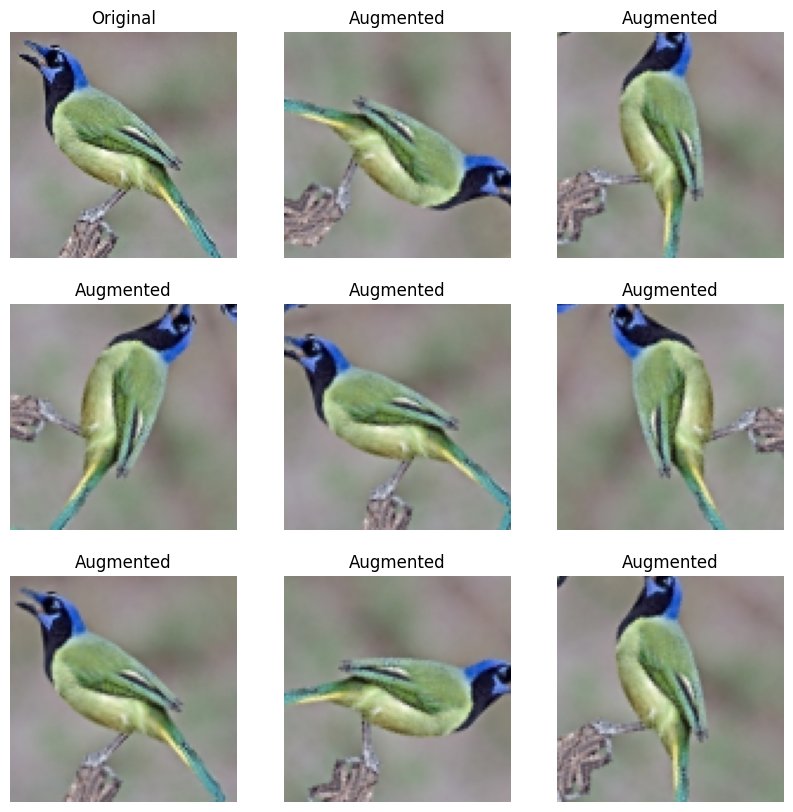

In [19]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]

    for i in range(1,9):
      ax = plt.subplot(3, 3, i + 1)
      augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      plt.imshow(augmented_image[0] / 255)
      plt.title("Augmented")
      plt.axis('off')

    ax = plt.subplot(3, 3, 1)
    plt.imshow(first_image / 255)
    plt.title("Original")
    plt.axis('off')

Puede encontrar los nombres de clase en el atributo **class_names** en estos conjuntos de datos. Estos corresponden a los nombres de los directorios en orden alfabético.

In [20]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(len(class_names))

525


In [21]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 96, 96, 3)
(64,)


# Modelo preentrenado

## Descargar MobileNetV2

In [22]:
# Modelo
mobilenet = keras.applications.MobileNetV2(
    input_shape=(img_shape, img_shape, 3),
    include_top=False,
    weights="imagenet",
)

# Preprocesamiento
mobilenet_prep = keras.applications.mobilenet_v2.preprocess_input

9406464/9406464 [==============================] - 1s 0us/step


In [23]:
mobilenet.trainable = False

In [24]:
mobilenet.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0

In [25]:
# model_layers = mobilenet.layers

# for layer in model_layers[-3:]:
#     print(f"Layer name: {layer.name} Trainable: {layer.trainable}")
#     if isinstance(layer, layers.GlobalAveragePooling2D):
#         pooling_layer = layer.name

# pooling_layer = mobilenet.get_layer(pooling_layer).output
# new_last_layer = layers.Dense(num_classes, activation="softmax")(pooling_layer)

# custom_mobilenet = keras.Model(mobilenet.input, new_last_layer)

In [26]:
# for layer in custom_mobilenet.layers[-3:]:
#     print(f"Layer name: {layer.name} Trainable: {layer.trainable}")

In [27]:
global_average_layer = layers.GlobalAveragePooling2D()
classifier = layers.Dense(num_classes, activation="softmax")

inputs = keras.Input(shape=(img_shape, img_shape, 3))
x = data_augmentation(inputs)
x = mobilenet_prep(x)
x = mobilenet(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)
outputs = classifier(x)
custom_mobilenet = keras.Model(inputs, outputs)

In [32]:
initial_learning_rate = 0.0001
custom_mobilenet.compile(
    optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics   = ['accuracy']
)

## Ejemplo del preprocesamiento de MobileNetV2

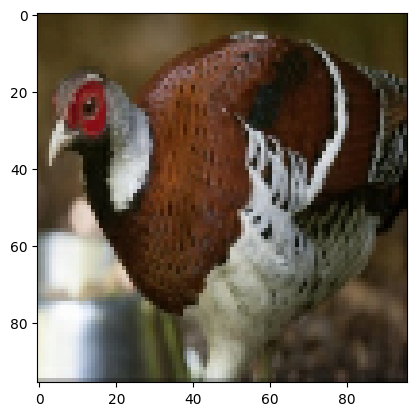

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


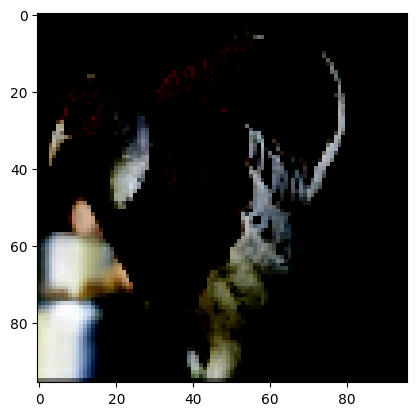

In [33]:
img = train_dataset.take(1)
img = next(iter(img))[0][0]
plt.imshow(img / 255.0)
plt.show()

prep_img = mobilenet_prep(img)
plt.imshow(prep_img, vmin=np.min(prep_img), vmax=np.max(prep_img))
plt.show()

In [34]:
custom_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                             

In [35]:
dummy = np.random.randn(16, img_shape, img_shape, 3)

output = custom_mobilenet(dummy)
print(f"{output.shape = }")

output.shape = TensorShape([16, 525])


In [36]:
import time

epochs = 10
t1 = time.time()
history1 = custom_mobilenet.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1)
t2 = time.time()

print(f"Training time: {(t2-t1)/60:.2f} minutes")

Epoch 1/10
   1/1323 [..............................] - ETA: 1:12:20 - loss: 7.2996 - accuracy: 0.0000e+00

2024-04-23 15:11:26.729367: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fda88a9b010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-23 15:11:26.729407: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-04-23 15:11:26.746767: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713885086.855754    1175 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1323/1323 [==============================] - 88s 64ms/step - loss: 4.5217 - accuracy: 0.1708 - val_loss: 3.0185 - val_accuracy: 0.4808
Epoch 2/10
1323/1323 [==============================] - 40s 30ms/step - loss: 2.7007 - accuracy: 0.4475 - val_loss: 2.0423 - val_accuracy: 0.6362
Epoch 3/10
1323/1323 [==============================] - 39s 29ms/step - loss: 2.0892 - accuracy: 0.5548 - val_loss: 1.6042 - val_accuracy: 0.7063
Epoch 4/10
1323/1323 [==============================] - 39s 30ms/step - loss: 1.7822 - accuracy: 0.6058 - val_loss: 1.3548 - val_accuracy: 0.7387
Epoch 5/10
1323/1323 [==============================] - 40s 30ms/step - loss: 1.5965 - accuracy: 0.6390 - val_loss: 1.2005 - val_accuracy: 0.7627
Epoch 6/10
1323/1323 [==============================] - 40s 30ms/step - loss: 1.4664 - accuracy: 0.6632 - val_loss: 1.0897 - val_accuracy: 0.7794
Epoch 7/10
1323/1323 [==============================] - 40s 30ms/step - loss: 1.3742 - accuracy: 0.6805 - val_loss: 1.0123 - val_accura

# Visualiza los resultados del entrenamiento

Cree gráficos de pérdida y precisión en los conjuntos de entrenamiento y validación:

In [37]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

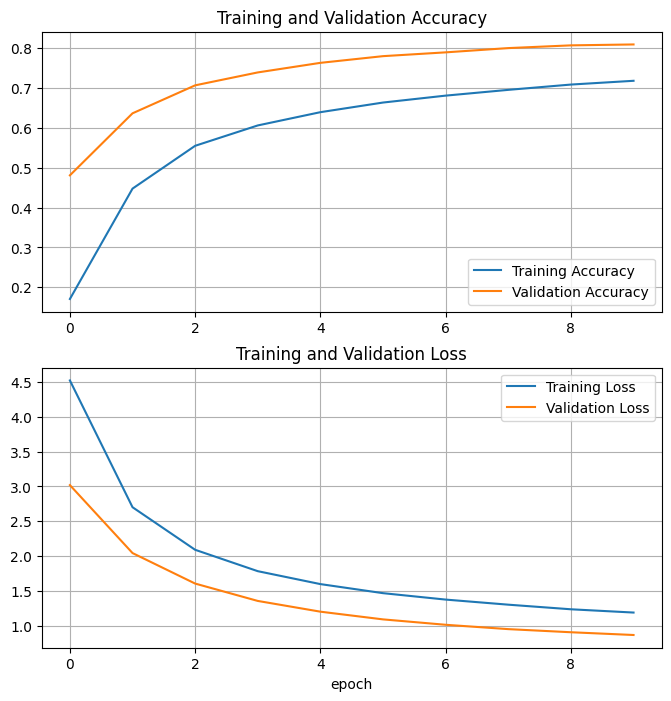

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

# Fine tuning
Tunearemos más capas con un learning rate muy bajo

In [39]:
mobilenet.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [41]:
custom_mobilenet.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate / 10),
    metrics   = ['accuracy'],
)

In [42]:
custom_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                             

In [43]:
fine_tune_epochs = epochs
total_epochs =  epochs + fine_tune_epochs

history_fine = custom_mobilenet.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history1.epoch),
                         validation_data=val_dataset)

Epoch 11/20
1323/1323 [==============================] - 180s 111ms/step - loss: 0.9649 - accuracy: 0.7527 - val_loss: 0.5730 - val_accuracy: 0.8514
Epoch 12/20
1323/1323 [==============================] - 110s 83ms/step - loss: 0.8522 - accuracy: 0.7793 - val_loss: 0.5410 - val_accuracy: 0.8526
Epoch 13/20
1323/1323 [==============================] - 86s 64ms/step - loss: 0.7853 - accuracy: 0.7943 - val_loss: 0.5131 - val_accuracy: 0.8621
Epoch 14/20
1323/1323 [==============================] - 77s 58ms/step - loss: 0.7361 - accuracy: 0.8047 - val_loss: 0.5061 - val_accuracy: 0.8663
Epoch 15/20
1323/1323 [==============================] - 76s 58ms/step - loss: 0.6936 - accuracy: 0.8141 - val_loss: 0.4846 - val_accuracy: 0.8674
Epoch 16/20
1323/1323 [==============================] - 76s 57ms/step - loss: 0.6554 - accuracy: 0.8254 - val_loss: 0.4743 - val_accuracy: 0.8678
Epoch 17/20
1323/1323 [==============================] - 76s 57ms/step - loss: 0.6277 - accuracy: 0.8324 - val_loss

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

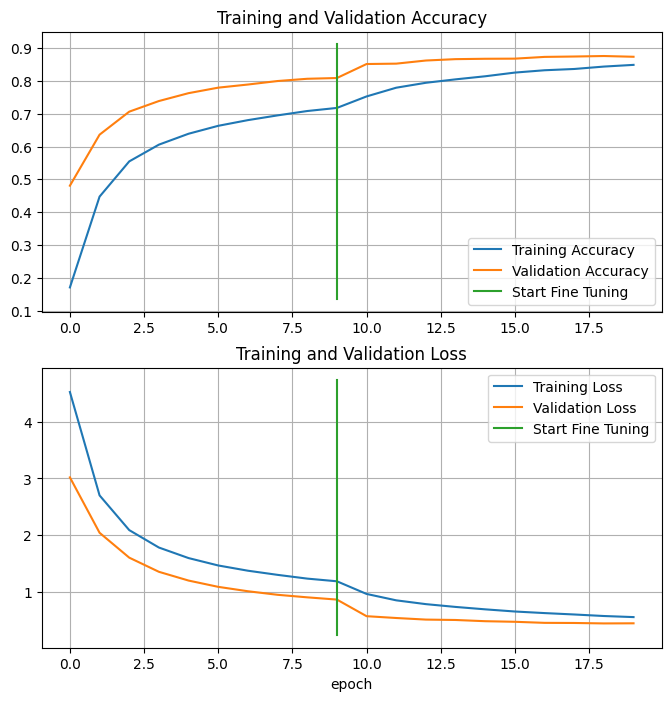

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.1, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 3.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(True)
plt.show()

In [49]:
custom_mobilenet.save("custom_mobilenet.keras")

In [50]:
loss, accuracy = custom_mobilenet.evaluate(test_dataset)

42/42 [==============================] - 1s 25ms/step - loss: 0.3599 - accuracy: 0.8979


In [51]:
print(F"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.3599, Accuracy: 0.8979


In [52]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Hacer predicciones en los datos de prueba
predictions = custom_mobilenet.predict(val_dataset)

# Convertir las predicciones de las etiquetas codificadas one-hot a etiquetas numéricas
predicted_labels = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales de los datos de prueba
true_labels = []
for features, labels in val_dataset:
    true_labels.extend(labels.numpy())

print(f"Predicted labels length: {len(predicted_labels)}")
print(f"True labels length: {len(true_labels)}")

# Calcular la matriz de confusión
# confusion_mtx = confusion_matrix(true_labels, predicted_labels)

# print(confusion_mtx)

42/42 [==============================] - 2s 27ms/step
Predicted labels length: 2625
True labels length: 2625


In [53]:
from sklearn.metrics import classification_report

clasiff_report = classification_report(true_labels, predicted_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
print(clasiff_report)

              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       1.00      0.20      0.33         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      0.60      0.75         5
           5       1.00      1.00      1.00         5
           6       1.00      0.80      0.89         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      0.80      0.89         5
          11       1.00      0.80      0.89         5
          12       0.83      1.00      0.91         5
          13       1.00      0.80      0.89         5
          14       0.75      0.60      0.67         5
          15       1.00      1.00      1.00         5
          16       0.83      1.00      0.91         5
          17       0.67    